C:\Users\Ctarg07\AppData\Local\Temp\ipykernel_12564\4065017676.py:27: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  lamda_solution = fsolve(energy_eq, initial_guess)


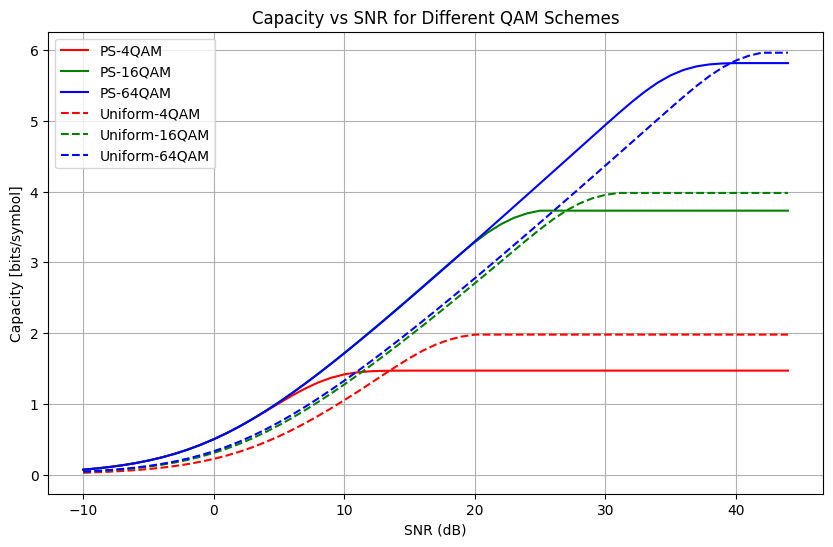

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy import special
from scipy.stats import norm
from scipy.integrate import quad
from scipy.optimize import fsolve

class PS_QAM:
    def __init__(self, M, E_av, Eav_N0_dB):
        self.M = M
        self.x = (2*np.arange(1, self.M+1)-self.M -1)/(self.M - 1)
        self.E_av = E_av
        self.lamda = self.find_lambda()
        self.p_xm = self.find_pxm()
        self.Eav_N0 = 1/2*10**(Eav_N0_dB/10) 
        self.PMF_QAM = self.find_PMF_QAM()
        self.N_0 = self.E_av/self.Eav_N0
        self.x_uni = self.x*(self.E_av/(np.sum(self.x**2)/self.M)) 
    def find_lambda(self):
        def energy_eq(lamda):
            numerator = np.sum(np.abs(self.x)**2 * np.exp(-lamda * np.abs(self.x)**2))
            denominator = np.sum(np.exp(-lamda * np.abs(self.x)**2))
            return (numerator / denominator) - self.E_av
        initial_guess = 1.0
        lamda_solution = fsolve(energy_eq, initial_guess)
        
        return lamda_solution[0]
    def find_pxm(self):
        p_xm = np.zeros(self.M)
        SIGMA = 0
        for i in range(self.M):
            SIGMA += np.exp(-self.x[i]**2*self.lamda)
        for i in range(self.M):
            p_xm[i] = np.exp(-self.x[i]**2*self.lamda)/SIGMA
        return p_xm
    
    def find_E_av(self):
        Av = 0
        for i in range(self.M):
            Av += self.x[i]**2*self.p_xm[i]
        return Av
    
    def find_PMF_QAM(self):
        PMF_QAM = np.zeros((self.M, self.M))
        for i in range(self.M):
            for j in range(self.M):
                PMF_QAM[i,j] = np.transpose(self.p_xm[i])*self.p_xm[j]
        return PMF_QAM
    
    def find_py(self,y):
        func = 0
        p_y = 0
        SIGMA = 0
        for i in range(self.M):
            SIGMA += np.exp(-self.x[i]**2*self.lamda)
        for i in range(self.M):
            p_y += 1/(np.sqrt(np.pi*self.N_0))*np.exp(-(y-self.x[i])**2/self.N_0)*np.exp(-self.lamda*self.x[i]**2)/SIGMA
        if p_y < 10**-300:
            p_y = 10**-300
        func = - p_y*np.log2(p_y)
        return func
    
    def entropy(self):
        T = 0
        T,_ = quad(self.find_py,-60,60,limit = 5000) - np.log2(np.sqrt(2*np.pi* np.e * self.N_0/2))
        return T

    def find_uni(self,y):
        p_y = 0
        func = 0
        for i in range(self.M):
            p_y += 1/(np.sqrt(np.pi*self.N_0))*np.exp(-(y-self.x_uni[i])**2/self.N_0)*(1/self.M)
        if p_y < 10**-300:
            p_y = 10**-300
        func = -p_y*np.log2(p_y)
        return func
    
    def entropy_uni(self):
        T = 0
        T,_ = quad(self.find_uni,-60,60,limit = 5000) - np.log2(np.sqrt(2*np.pi* np.e * self.N_0/2))
        return T
    
    def shannon(self):
        T = np.log2(1+self.Eav_N0)
        return T
    
    def plot_PMF_QAM(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        xpos, ypos = np.meshgrid(self.x, self.x)
        xpos = xpos.flatten()
        ypos = ypos.flatten()
        zpos = np.zeros_like(xpos)
        
        dx = dy = 0.35
        dz = self.PMF_QAM.flatten()  

        
        norm = plt.Normalize(dz.min(), dz.max())
        colors = cm.viridis(norm(dz))

        ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors, shade=True)
        
        ax.set_xlabel('Real')
        ax.set_ylabel('Image')
        ax.set_zlabel('Probability')

        plt.title('64_QAM with Maxwell-Boltzmann distribution, lamda = 0.3')
        plt.show()

Es_N0_dB = np.arange(-10,45)  
shanonn = np.zeros(len(Es_N0_dB))
MI_4QAM = np.zeros(len(Es_N0_dB))
MI_16QAM = np.zeros(len(Es_N0_dB))
MI_64QAM = np.zeros(len(Es_N0_dB))
for i in range(len(Es_N0_dB)):
    MI_4QAM[i] = PS_QAM(4, 0.2, Es_N0_dB[i]).entropy()
    if i > 30:
        MI_4QAM[i] = MI_4QAM[30]
for i in range(len(Es_N0_dB)):
    MI_16QAM[i] = PS_QAM(16, 0.2, Es_N0_dB[i]).entropy()
    if i > 35:
        MI_16QAM[i] = MI_16QAM[35]
for i in range(len(Es_N0_dB)):
    MI_64QAM[i] = PS_QAM(64, 0.2, Es_N0_dB[i]).entropy()
    if i > 50:
        MI_64QAM[i] = MI_64QAM[50]
for i in range(len(Es_N0_dB)):
    shanonn[i] = PS_QAM(4, 0, Es_N0_dB[i]).shannon()
MI_4QAM_Uni = np.zeros(len(Es_N0_dB))
MI_16QAM_Uni = np.zeros(len(Es_N0_dB))
MI_64QAM_Uni = np.zeros(len(Es_N0_dB))
for i in range(len(Es_N0_dB)):
    MI_4QAM_Uni[i] = PS_QAM(4, 0.2, Es_N0_dB[i]).entropy_uni()
    if i > 30:
        MI_4QAM_Uni[i] = MI_4QAM_Uni[30]
for i in range(len(Es_N0_dB)):
    MI_16QAM_Uni[i] = PS_QAM(16, 0.2, Es_N0_dB[i]).entropy_uni()
    if i > 41:
        MI_16QAM_Uni[i] = MI_16QAM_Uni[41]
for i in range(len(Es_N0_dB)):
    MI_64QAM_Uni[i] = PS_QAM(64, 0.2, Es_N0_dB[i]).entropy_uni()
    if i > 52:
        MI_64QAM_Uni[i] = MI_64QAM_Uni[52]

plt.figure(figsize=(10, 6))
plt.plot(Es_N0_dB, MI_4QAM, 'r-', label='PS-4QAM')
plt.plot(Es_N0_dB, MI_16QAM, 'g-', label='PS-16QAM')
plt.plot(Es_N0_dB, MI_64QAM, 'b-', label='PS-64QAM')

plt.plot(Es_N0_dB, MI_4QAM_Uni, 'r--', label='Uniform-4QAM')
plt.plot(Es_N0_dB, MI_16QAM_Uni, 'g--', label='Uniform-16QAM')
plt.plot(Es_N0_dB, MI_64QAM_Uni, 'b--', label='Uniform-64QAM')
plt.xlabel('SNR (dB)')
plt.ylabel('Capacity [bits/symbol]')
plt.title('Capacity vs SNR for Different QAM Schemes')

plt.legend()

plt.grid(True)
plt.show()
